# Cycles

This notebook explains how I fit different cycles to the passenger data, and provides nice visuals.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy import optimize

In [2]:
import sys
sys.path.append('../src/')
import aposch_functions as aposch

## Get df04_train dataset

In [3]:
# read in data
data2019 = pd.read_csv('../data/2019_RAW_APC_Data.csv.gz')

# get df04
df04 = aposch.clean_data(data2019)

# split into test/train sets
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

## Fit seasonal cycle (sinusoidal curve)


Let's get started. Find the mean crowdedness by day (agnostic of station or of hour):

In [4]:
pw_agg_doy = df04_train.groupby(['DOY'])['passwithin'].mean()
cr_agg_doy = df04_train.groupby(['DOY'])['Crowded'].mean()
pw_agg_woy = df04_train.groupby(['WOY'])['passwithin'].mean()
cr_agg_woy = df04_train.groupby(['WOY'])['Crowded'].mean()

Fit a sine curve with period 1 year:

In [5]:
def sinu(x, a, c, d):
    b = 6.28/52 # forces the period to be 1 year
    return a * np.sin(b * (x - c)) + d

params, params_covariance = optimize.curve_fit(sinu, pw_agg_woy.index, pw_agg_woy,
                                               p0=[3, 13, 33])

Plot it by week:

Text(0.5, 0, 'Week of year')

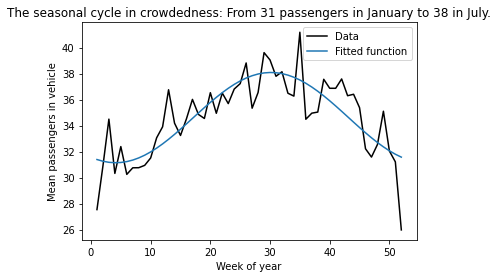

In [6]:
x_data = pw_agg_woy.index
y_data = pw_agg_woy
y_sinu_year = pd.Series(data=sinu(x_data, params[0], params[1], params[2]),
                   index=x_data)


plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', c='black')
plt.plot(x_data, y_sinu_year,
         label='Fitted function')
plt.title('The seasonal cycle in crowdedness: From 31 passengers in January to 38 in July.')
plt.legend(loc='best')
plt.ylabel('Mean passengers in vehicle')
plt.xlabel('Week of year')


Do some data manipulation:

In [7]:
# create a day-level dataframe with the columns we need
byday = aposch.create_byday(pw_agg_doy, pw_agg_woy, y_sinu_year)

Now a plot at the day of year level:

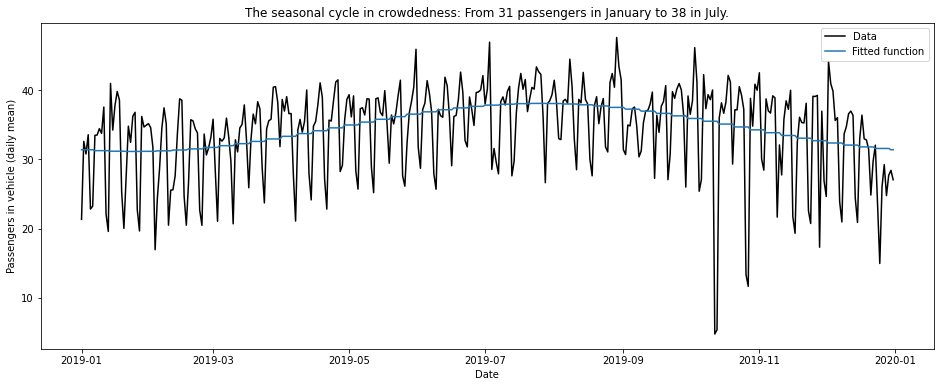

In [8]:
x_data = byday['Date']
y_data = byday['DayMeanPassw']
y_sinu_year = byday['Sinu01Passw']


plt.figure(figsize=(16, 6))
plt.plot(x_data, y_data, label='Data', c='black')
plt.plot(x_data, y_sinu_year,
         label='Fitted function')
plt.title('The seasonal cycle in crowdedness: From 31 passengers in January to 38 in July.')
plt.legend(loc='best')
plt.ylabel('Passengers in vehicle (daily mean)')
plt.xlabel('Date')
plt.savefig('../images/DateSeasonal1.png', bbox_inches='tight')

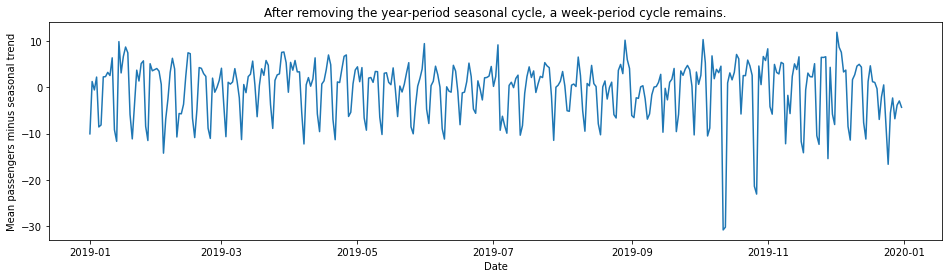

In [9]:
x_data = byday['Date']
y_data = byday['Removed01']

plt.figure(figsize=(16,4))
plt.plot(x_data, y_data)
plt.xlabel('Date')
plt.ylabel('Mean passengers minus seasonal trend')
plt.title('After removing the year-period seasonal cycle, a week-period cycle remains.')
plt.savefig('../images/DateSeasonal2.png', bbox_inches='tight')

Here I'll stop and address what you may be thinking: October 26-27 and October 12-13 were big dips in passengers. These dips in passengers came from planned construction that closed the downtown section of the line. https://www.soundtransit.org/get-to-know-us/news-events/news-releases/construction-will-close-light-rail-downtown-seattle-three

## Fit week-period cycle

Data manipulation:

(Note - "fitting" the weekday/weekend trend happens within the create_bydow() function. It simply groups data by weekend/weekday and takes the mean.

In [10]:
bydow = aposch.create_bydow(byday)

In [11]:
byday = aposch.improve_byday(byday, bydow)

A plot at the day of week level:

Text(0.5, 1.0, 'This is the average week-period cycle. Weekends have fewer passengers than weekdays.')

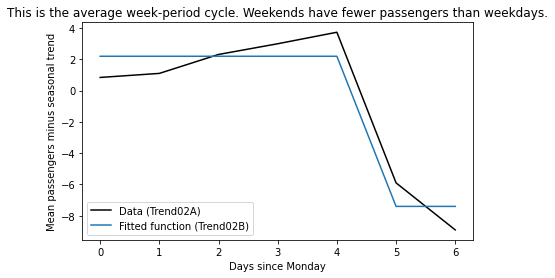

In [12]:
plt.figure(figsize=(7,4))
plt.plot(bydow['Cycle02A'], label='Data (Trend02A)', c='black')
plt.plot(bydow['Cycle02B'],
         label='Fitted function (Trend02B)')
plt.legend(loc='best')
plt.xlabel('Days since Monday')
plt.ylabel('Mean passengers minus seasonal trend')
plt.title('This is the average week-period cycle. Weekends have fewer passengers than weekdays.')

Visualize day-of-year level data after we remove each of the above.

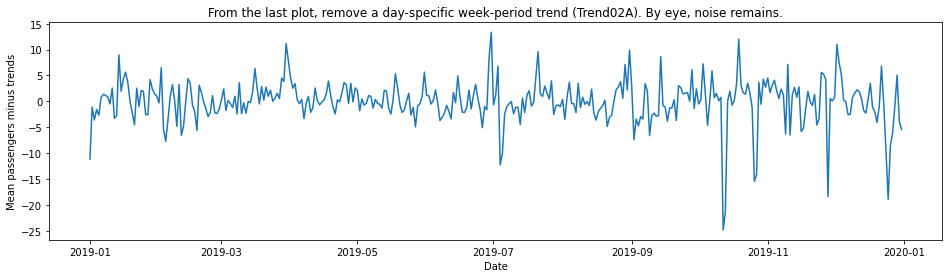

In [13]:
x_data = byday['Date']
y_data = byday['Removed02A']

plt.figure(figsize=(16,4))
plt.plot(x_data, y_data)
plt.xlabel('Date')
plt.ylabel('Mean passengers minus trends')
plt.title('From the last plot, remove a day-specific week-period trend (Trend02A). By eye, noise remains.')
plt.savefig('../images/DateWeekPrd1.png', bbox_inches='tight')

Text(0.5, 1.0, 'From the last plot, remove a weekend-weekday week-period trend (Trend02B). By eye, a week-period trend remains.')

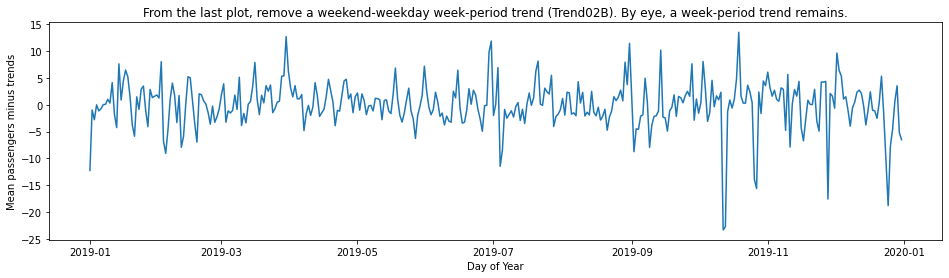

In [14]:
x_data = byday['Date']
y_data = byday['Removed02B']

plt.figure(figsize=(16,4))
plt.plot(x_data, y_data)
plt.xlabel('Day of Year')
plt.ylabel('Mean passengers minus trends')
plt.title('From the last plot, remove a weekend-weekday week-period trend (Trend02B). By eye, a week-period trend remains.')

Looking at the two plots above, the former is slightly better because more of the week-period cycle is removed.

#### Create all these variables in df04_train. Call it df05_train.

In [15]:
df05_train = aposch.create_df05_train(df04_train, byday, bydow)

df05_train has all the same observations as df04_train, just with extra features.
- 'Sinu01Passw' is the year-period sinu curve for passwithin
- 'Removed01' is the actual passwithin minus the sinu curve value of that week.
- 'Cycle02A' is the week-period day-grain cycle
- 'Cycle02B' is the week-period coarse (weekday/weekend) cycle
- 'Removed02A' is 'Removed01' minus 'Cycle02A'.
- 'Removed02B' is 'Removed01' minus 'Cycle02B'.